# 🚀 Project: Concrete Crack Detection with CNNs

**Team members:** Oliver, Patrick  
**Date:** 13.12.2025

Using device: cuda
Extracting dataset...
Data ready: 6000 Val images, 6000 Test images.
Loading MobileNetV2 (Epoch 6)...
-> Loaded.
Loading OPNet (Epoch 9)...
-> Loaded.

=== 10. ERROR ANALYSIS ===
Analyzing MobileNetV2...


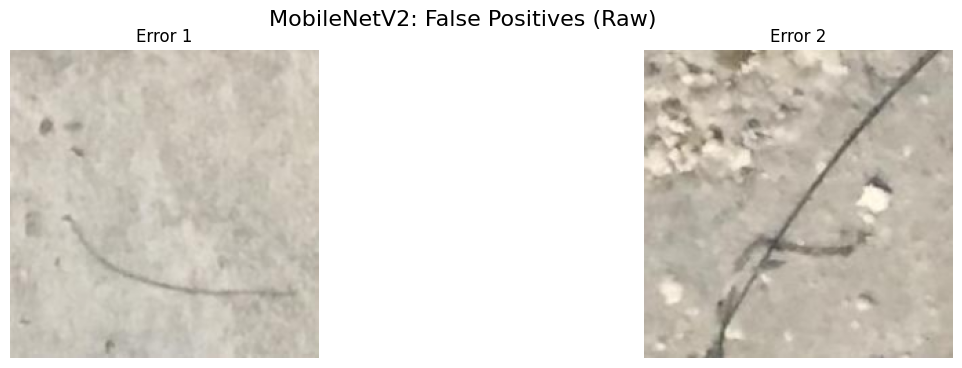

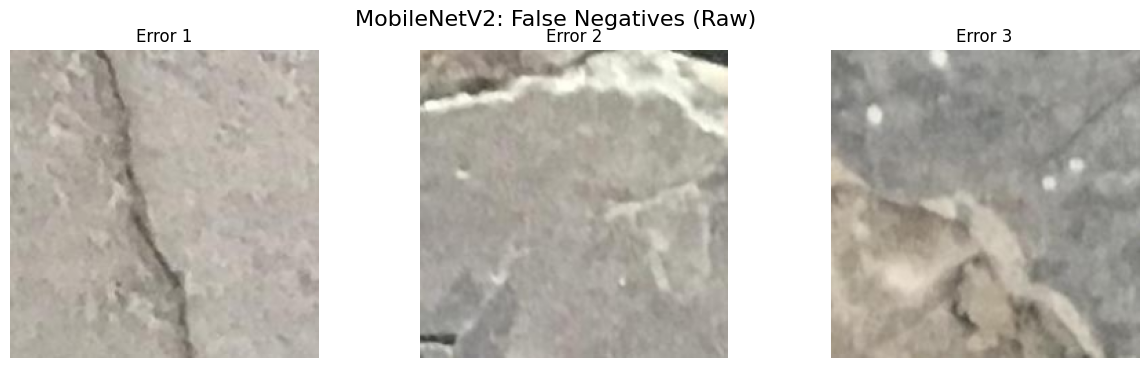

Analyzing OPNet...


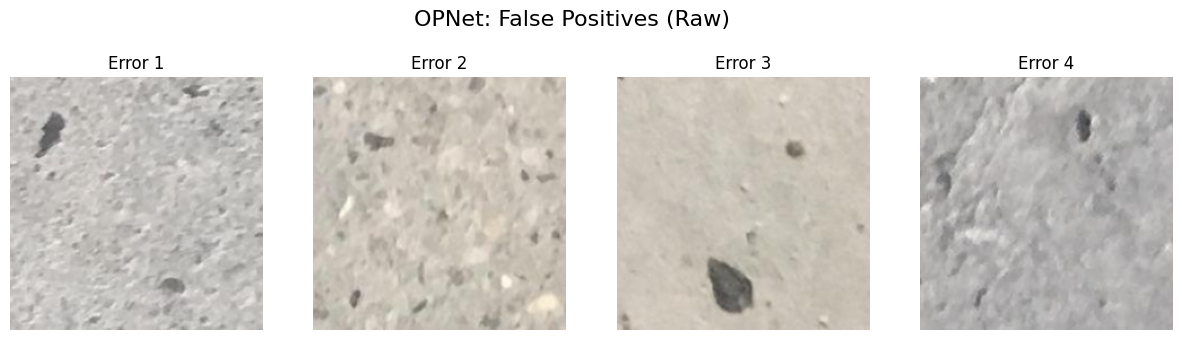

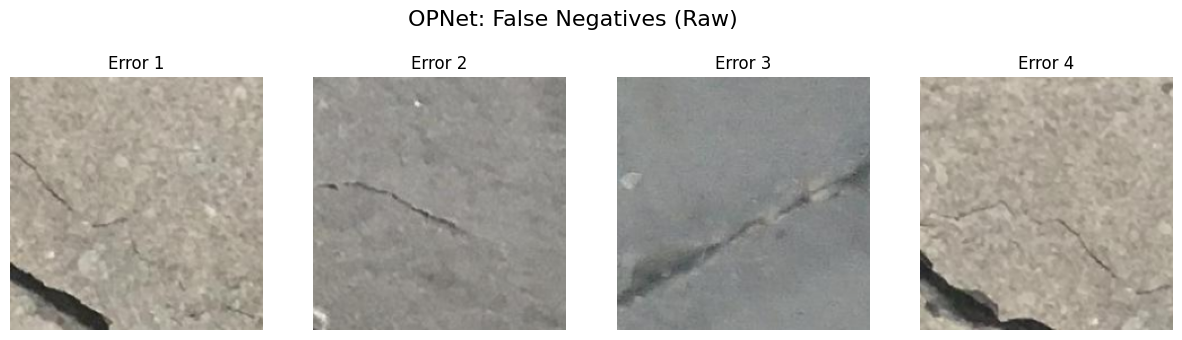


=== 11. EXPLAINABILITY (Grad-CAM) ===


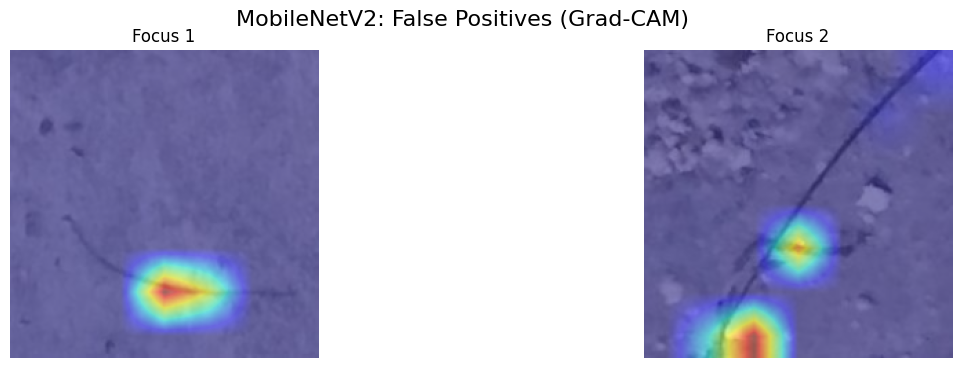

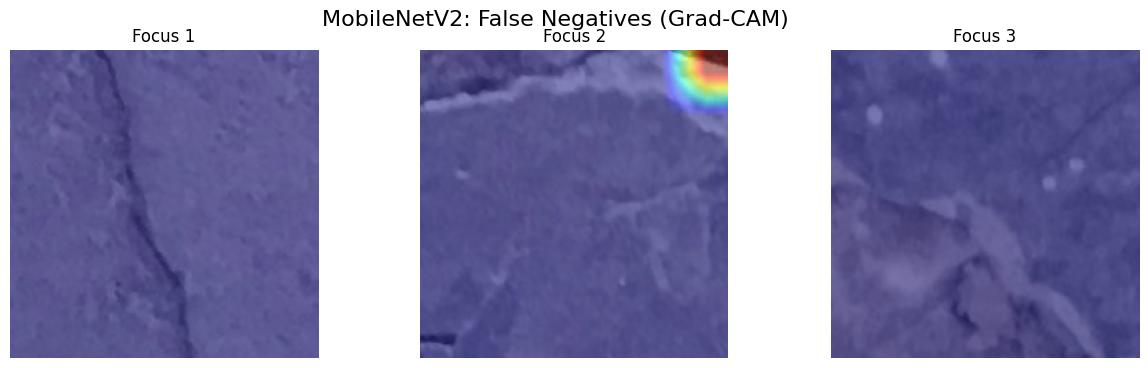

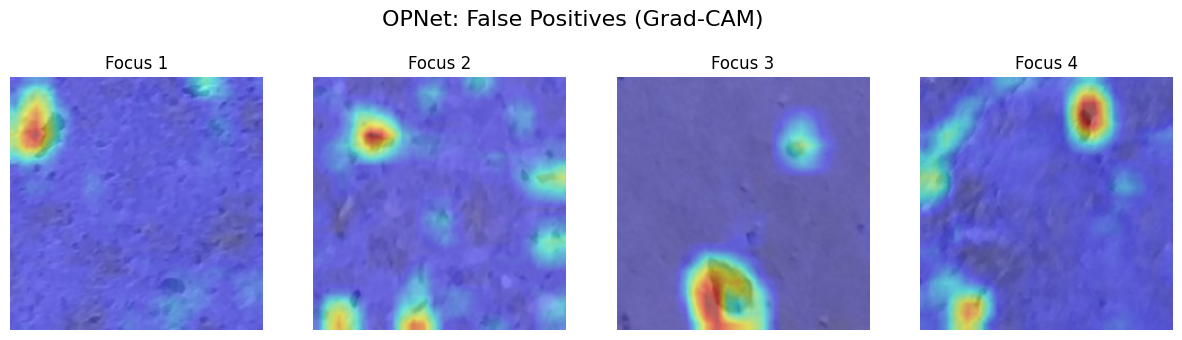

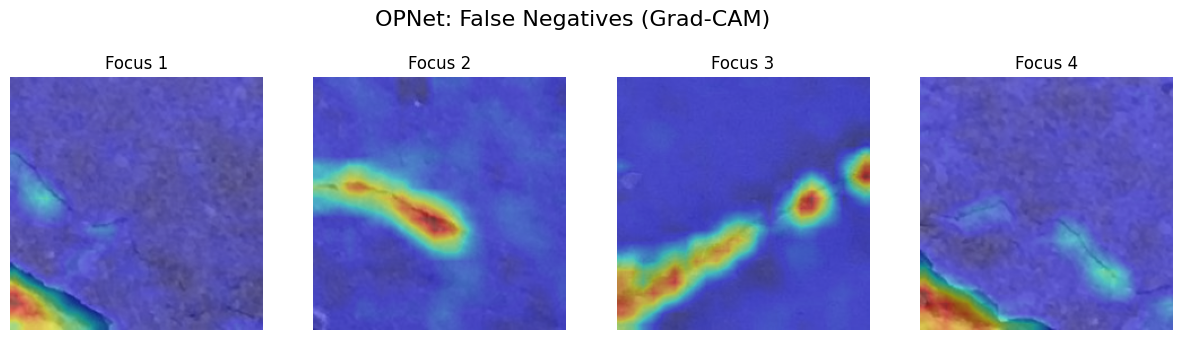


=== 12. FINAL TEST SET EVALUATION ===
--- MobileNetV2 (Winner) Results ---
Recall (Sensitivity): 0.9987
Specificity:          0.9993
Accuracy:             0.9990
F1-Score:             0.9990

--- OPNet (Winner) Results ---
Recall (Sensitivity): 0.9983
Specificity:          0.9967
Accuracy:             0.9975
F1-Score:             0.9975



In [1]:
# =============================================================================
# SETUP: Imports, Data Loading & Model Definitions
# =============================================================================

import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, f1_score

# 1. Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Define Paths
BASE_DIR = os.getcwd()
DATASET_ZIP = os.path.join(BASE_DIR, "archive.zip")
EXTRACT_PATH = os.path.join(BASE_DIR, "concrete_data")
MODEL_DIR = os.path.join(BASE_DIR, "models") 

# 3. Prepare Data (Extract & Split)
# We need to recreate exactly the same split as in training (random_state=42)
if not os.path.exists(EXTRACT_PATH):
    print("Extracting dataset...")
    with zipfile.ZipFile(DATASET_ZIP, 'r') as z: z.extractall(EXTRACT_PATH)

pos_path = os.path.join(EXTRACT_PATH, "Positive")
neg_path = os.path.join(EXTRACT_PATH, "Negative")
all_files = [(os.path.join(pos_path, f), 1) for f in os.listdir(pos_path) if f.endswith('.jpg')] + \
            [(os.path.join(neg_path, f), 0) for f in os.listdir(neg_path) if f.endswith('.jpg')]

df = pd.DataFrame(all_files, columns=['filepath', 'label'])
# 70% Train, 15% Val, 15% Test (Stratified)
X_train, X_temp, y_train, y_temp = train_test_split(df['filepath'], df['label'], test_size=0.3, random_state=42, stratify=df['label'])
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 4. Dataset & Loaders
class ConcreteDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = filepaths.values; self.labels = labels.values; self.transform = transform
    def __len__(self): return len(self.filepaths)
    def __getitem__(self, idx):
        img = Image.open(self.filepaths[idx]).convert("RGB")
        return self.transform(img) if self.transform else img, self.labels[idx]

# Only Validation/Test Transforms (No Augmentation)
eval_transforms = transforms.Compose([
    transforms.Resize((224, 224)), transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_loader = DataLoader(ConcreteDataset(X_val, y_val, eval_transforms), batch_size=32, shuffle=False)
test_loader = DataLoader(ConcreteDataset(X_test, y_test, eval_transforms), batch_size=32, shuffle=False)
print(f"Data ready: {len(X_val)} Val images, {len(X_test)} Test images.")

# 5. Define Architectures & Load Weights
class OPNet(nn.Module):
    def __init__(self):
        super(OPNet, self).__init__()
        self.block1 = nn.Sequential(nn.Conv2d(3, 32, 3, 1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2))
        self.block2 = nn.Sequential(nn.Conv2d(32, 64, 3, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2))
        self.block3 = nn.Sequential(nn.Conv2d(64, 128, 3, 1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2))
        self.block4 = nn.Sequential(nn.Conv2d(128, 256, 3, 1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2))
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(256, 1))
    def forward(self, x):
        x = self.block1(x); x = self.block2(x); x = self.block3(x); x = self.block4(x)
        return self.classifier(self.global_avg_pool(x).view(x.size(0), -1))

def load_model(name, epoch):
    print(f"Loading {name} (Epoch {epoch})...")
    if "MobileNet" in name:
        model = models.mobilenet_v2(weights=None)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    else: model = OPNet()
    
    # Construct filename (Match your saved file naming convention!)
    # Example: "MobileNetV2_epoch_6.pth" or "OPNet_epoch_9.pth"
    fname = f"{name.replace(' ', '_')}_epoch_{epoch}.pth"
    path = os.path.join(MODEL_DIR, fname)
    
    if os.path.exists(path):
        model.load_state_dict(torch.load(path, map_location=device))
        print("-> Loaded.")
    else:
        print(f"-> ERROR: {fname} not found in models/ folder!")
    return model.to(device).eval()

# --- LOAD BEST MODELS ---
# Adjust filenames/epochs here based on your best training results!
best_mb = load_model("MobileNetV2", epoch=6) 
best_op = load_model("OPNet", epoch=9)       


# =============================================================================
# Step 10: Error Analysis (Visual Inspection)
# =============================================================================
print("\n=== 10. ERROR ANALYSIS ===")

def find_errors(model, loader, num=4):
    fps, fns = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            preds = (torch.sigmoid(model(inputs)) > 0.5).float().cpu()
            labels = labels.cpu()
            
            # Use argwhere to find indices
            fps.extend(inputs[(preds.squeeze() == 1) & (labels == 0)].cpu())
            fns.extend(inputs[(preds.squeeze() == 0) & (labels == 1)].cpu())
            
            if len(fps) >= num and len(fns) >= num: break
    return fps[:num], fns[:num]

def show_images(images, title):
    if not images: return
    plt.figure(figsize=(15, 4))
    inv_norm = transforms.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225])
    for i, img in enumerate(images):
        img = inv_norm(img).permute(1, 2, 0).numpy()
        plt.subplot(1, len(images), i+1); plt.imshow(np.clip(img, 0, 1)); plt.axis('off')
        plt.title(f"Error {i+1}")
    plt.suptitle(title, fontsize=16); plt.show()

# Find & Show
print("Analyzing MobileNetV2...")
mb_fps, mb_fns = find_errors(best_mb, val_loader)
show_images(mb_fps, "MobileNetV2: False Positives (Raw)")
show_images(mb_fns, "MobileNetV2: False Negatives (Raw)")

print("Analyzing OPNet...")
op_fps, op_fns = find_errors(best_op, val_loader)
show_images(op_fps, "OPNet: False Positives (Raw)")
show_images(op_fns, "OPNet: False Negatives (Raw)")


# =============================================================================
# Step 11: Explainability (Grad-CAM)
# =============================================================================
print("\n=== 11. EXPLAINABILITY (Grad-CAM) ===")

class GradCAM:
    def __init__(self, model, target):
        self.model = model; self.grads = None; self.acts = None
        self.h1 = target.register_forward_hook(lambda m,i,o: setattr(self, 'acts', o))
        self.h2 = target.register_full_backward_hook(lambda m,gi,go: setattr(self, 'grads', go[0]))
    def remove(self): self.h1.remove(); self.h2.remove()
    def __call__(self, x):
        out = self.model(x); self.model.zero_grad(); out[:,0].backward(retain_graph=True)
        w = torch.mean(self.grads, dim=(2,3), keepdim=True)
        cam = torch.relu(torch.sum(w * self.acts, dim=1, keepdim=True))
        cam = torch.nn.functional.interpolate(cam, size=x.shape[2:], mode='bilinear', align_corners=False)
        return cam.detach().cpu().numpy()

def plot_gradcam(images, cam, title):
    if not images: return
    plt.figure(figsize=(15, 4))
    inv_norm = transforms.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225])
    for i, img_t in enumerate(images):
        inp = img_t.unsqueeze(0).to(device); inp.requires_grad = True
        mask = cam(inp)[0, 0]
        mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-7)
        img = inv_norm(img_t).permute(1, 2, 0).numpy()
        plt.subplot(1, len(images), i+1); plt.imshow(np.clip(img, 0, 1)); plt.imshow(mask, alpha=0.5, cmap='jet')
        plt.title(f"Focus {i+1}"); plt.axis('off')
    plt.suptitle(title, fontsize=16); plt.show()

# Visualize
cam_mb = GradCAM(best_mb, best_mb.features[-1])
plot_gradcam(mb_fps, cam_mb, "MobileNetV2: False Positives (Grad-CAM)")
plot_gradcam(mb_fns, cam_mb, "MobileNetV2: False Negatives (Grad-CAM)")
cam_mb.remove()

cam_op = GradCAM(best_op, best_op.block4[0])
plot_gradcam(op_fps, cam_op, "OPNet: False Positives (Grad-CAM)")
plot_gradcam(op_fns, cam_op, "OPNet: False Negatives (Grad-CAM)")
cam_op.remove()


# =============================================================================
# Step 12: Final Evaluation on Test Set
# =============================================================================
print("\n=== 12. FINAL TEST SET EVALUATION ===")

def evaluate(model, name):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in test_loader:
            preds = (torch.sigmoid(model(x.to(device))) > 0.5).float().cpu()
            y_true.extend(y.numpy()); y_pred.extend(preds.numpy())
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"--- {name} Results ---")
    print(f"Recall (Sensitivity): {recall_score(y_true, y_pred):.4f}")
    print(f"Specificity:          {tn / (tn + fp):.4f}")
    print(f"Accuracy:             {accuracy_score(y_true, y_pred):.4f}")
    print(f"F1-Score:             {f1_score(y_true, y_pred):.4f}\n")

evaluate(best_mb, "MobileNetV2 (Winner)")
evaluate(best_op, "OPNet (Winner)")